Learning Transformer

In [1]:
# --------------------------------------------------------------------
# Importing required libraries
# --------------------------------------------------------------------
import random
import numpy as np
import pandas as pd
import PIL.Image as Image
from glob import glob
from mymodels import VisionTransformer, ReconNet
from mymodels.unet import Unet
from mymodels.discriminatorv2 import Discriminator
import matplotlib.pyplot as plt
from myutils import imshow
from datetime import datetime


# importing pytorch functions
import torch
from torchvision.utils import make_grid
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as tvtransforms
from torch.nn import SmoothL1Loss, BCELoss

# importing utils required in th code
from utils import subsample
from utils import transforms
from utils.evaluate import ssim, psnr, nmse
from utils.losses import SSIMLoss

# Device
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = 'cuda'
np.random.seed(42)
random.seed(42)

print("******* STARTED AT ************", datetime.now())

/home/snt/miniconda3/envs/causal_env_transformer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/snt/miniconda3/envs/causal_env_transformer/lib/python3.10/site-packages/timm/models/helpers.py:7: FutureWarning: Importing from timm.models.helpers is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/snt/miniconda3/envs/causal_env_transformer/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


******* STARTED AT ************ 2024-12-20 14:50:22.000458


In [3]:
# --------------------------------------------------------------------
# Loading dataset
# --------------------------------------------------------------------
class ImagenetDataset(Dataset):
    def __init__(self, isval=False):

        if isval:
            ## combine paths of each imagenet validation image into a single list
            self.files = []
            pattern = "*.JPEG"
            for dir, _, _ in os.walk("./data/tiny-imagenet-200/test/images/"):
                self.files.extend(glob(os.path.join(dir, pattern)))
        else:
            ## combine paths of each imagenet training image into a single list
            self.files = []  # get path of each imagenet images
            pattern = "*.JPEG"
            for dir, _, _ in os.walk("./data/tiny-imagenet-200/train/"):
                self.files.extend(glob(os.path.join(dir, pattern)))

        ##################### Change image size ########################
        ############## for best model, use tvtransforms.Resize(64*3,), tvtransforms.RandomCrop(60*3),
        self.transform = tvtransforms.Compose(
            [
                tvtransforms.Resize(
                    64 * 3,
                ),  # original 320
                tvtransforms.RandomCrop(60 * 3),  # original 272
                tvtransforms.Grayscale(1),
                tvtransforms.RandomVerticalFlip(p=0.5),
                tvtransforms.RandomHorizontalFlip(p=0.5),
                tvtransforms.ToTensor(),
            ]
        )
        ################################################################

        self.factors = [2, 3, 4, 5, 6, 7, 8, 9, 10]

    def get_mask_func(
        self,
        samp_style,
        factor,
    ):
        center_fractions = 0.08 * 4 / factor
        if samp_style == "random":
            mask_func = subsample.RandomMaskFunc(
                center_fractions=[center_fractions],
                accelerations=[factor],
            )
        elif samp_style == "equidist":
            mask_func = subsample.EquispacedMaskFunc(
                center_fractions=[center_fractions],
                accelerations=[factor],
            )
        return mask_func

    def add_gaussian_noise(self, x):
        ch, row, col = x.shape
        mean = 0
        var = 0.05
        sigma = var**0.5
        gauss = np.random.normal(mean, sigma, (ch, row, col))
        gauss = gauss.reshape(ch, row, col)
        noisy = x + gauss
        return noisy.float()

    def __len__(
        self,
    ):

        return len(self.files)

    def __getitem__(self, idx):
        image = Image.open(self.files[idx]).convert("RGB")

        y = self.transform(image)

        if random.uniform(0, 1) < 0.5:
            y = torch.rot90(y, 1, [-2, -1])

        if random.uniform(0, 1) < 0.5:
            samp_style = "random"
        else:
            samp_style = "equidist"
        factor = random.choice(self.factors)
        mask_func = self.get_mask_func(samp_style, factor=5)
        masked_kspace, _ = transforms.apply_mask(y, mask_func)

        # masked_kspace = self.add_gaussian_noise(y)

        return (masked_kspace, y)


dataset = ImagenetDataset()
val_dataset = ImagenetDataset(isval=True)

# ntrain = len(dataset)
ntrain = 20
train_dataset, _ = torch.utils.data.random_split(
    dataset,
    [ntrain, len(dataset) - ntrain],
    generator=torch.Generator().manual_seed(42),
)
############## for best model, use batch_size = 45 (not sure)
batch_size = 2
epoch = 40
trainloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    # num_workers=1,  # This is set to 1 for debug issues
    pin_memory=True,
    generator=torch.Generator().manual_seed(42),
)
valloader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=True,
    # num_workers=1,
    pin_memory=True,
    generator=torch.Generator().manual_seed(42),
)

Test the mask

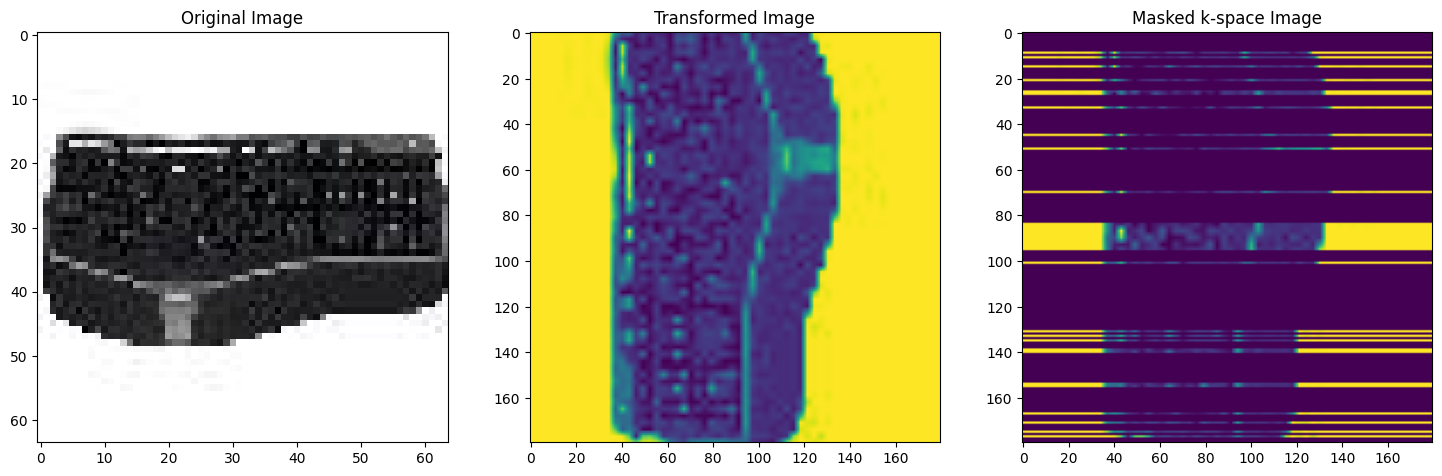

In [5]:
def test_image_transformation(dataset, idx):
    # 1. 加载原始图像
    original_image = Image.open(dataset.files[idx]).convert("RGB")
    original_image_np = np.array(original_image)  # 转为numpy数组方便显示

    # 2. 使用 __getitem__ 方法获取经过数据增强后的图像
    masked_kspace, transformed_image = dataset[idx]

    # 转换 PyTorch tensor 为 NumPy 数组进行显示和可视化
    transformed_image_np = transformed_image.numpy().transpose(
        1, 2, 0
    )  # 转换为 HWC 形式
    masked_kspace_np = masked_kspace.numpy().transpose(1, 2, 0)

    # 3. 显示原始图像和变换后的图像，以及 masked_kspace
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(original_image_np)
    axes[0].set_title("Original Image")
    axes[1].imshow(transformed_image_np)
    axes[1].set_title("Transformed Image")
    axes[2].imshow(masked_kspace_np)
    axes[2].set_title("Masked k-space Image")

    plt.show()


idx = 20  # 测试某个索引的图像
test_image_transformation(dataset, idx)

In [6]:
# --------------------------------------------------------------------
# Initialising Models
# --------------------------------------------------------------------
# Vision Transformer
############## for best model, use avrg_img_size = 180
avrg_img_size = 180
patch_size = 10
depth = 10
num_heads = 8
embed_dim = 44

net = VisionTransformer(
    avrg_img_size=avrg_img_size,
    patch_size=patch_size,
    in_chans=1,
    embed_dim=embed_dim,
    depth=depth,
    num_heads=num_heads,
    is_LSA=False,  # ---------------Parameter for adding LSA component
    is_SPT=False,  # ---------------Parameter for adding SPT component
    rotary_position_emb=True,  # ---------------Parameter for adding ROPE component
    use_pos_embed=False,
)

# --------------- network for testing Unet architecture
# Unet - Uncomment for running the U-net Code
# net = Unet(
#     in_chans=1,
#     out_chans=1,
#     chans=64,
#     num_pool_layers=4,
#     )

# --------------------------------------------------------------------
# Creating a reconstruction network
# --------------------------------------------------------------------
model = ReconNet(net).to(device)

# Set biases to zero
for name, param in model.named_parameters():
    if name.endswith(".bias"):
        torch.nn.init.constant_(param, 0)
        param.requires_grad = False

print("#Params:", sum(p.numel() for p in model.parameters() if p.requires_grad))
print(model)


# --------------------------------------------------------------------
# Function to Save model
# --------------------------------------------------------------------
def save_model(path, model, train_hist, optimizer, scheduler=None):
    net = model.net
    if scheduler:
        checkpoint = {
            "model": ReconNet(net),
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scheduler": scheduler.state_dict(),
        }
    else:
        checkpoint = {
            "model": ReconNet(net),
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        }

    torch.save(train_hist, path + "train_hist.pt")
    torch.save(checkpoint, path + "checkpoint.pth")


"""Choose optimizer"""
criterion = SSIMLoss().to(device)
optimizerG = optim.Adam(model.parameters(), lr=0.0)
train_hist = []
path = "./"  # Path for saving model checkpoint and loss history
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizerG,
    max_lr=0.0004,
    total_steps=epoch,
    pct_start=0.1,
    anneal_strategy="linear",
    cycle_momentum=False,
    base_momentum=0.0,
    max_momentum=0.0,
    div_factor=0.1 * epoch,
    final_div_factor=9,
)

# --------------------------------------------------------------------
# Start to train the model
# --------------------------------------------------------------------

# ----------- discriminator parameters to test Adverserial loss addition to the network
run_discriminator = False
if run_discriminator:
    criterionGAN = BCELoss().to(device)
    # criterionGAN = GANLoss().to(device)
    # discriminator = PatchDiscriminator(input_nc=1).to(device)
    discriminator = Discriminator(
        in_channels=1,
        patch_size=patch_size,
        extend_size=2,
        dim=50,
        blocks=depth,
        num_heads=8,
        dim_head=None,
        dropout=0.1,
    ).to(device)
    optimizerD = torch.optim.Adam(discriminator.parameters(), lr=0.00005)

    gan_weight = 0.05
    ss_weight = 1
    schedulerD = optim.lr_scheduler.OneCycleLR(
        optimizerD,
        max_lr=0.00005,
        total_steps=epoch,
        pct_start=0.1,
        anneal_strategy="linear",
        cycle_momentum=False,
        base_momentum=0.0,
        max_momentum=0.0,
        div_factor=0.1 * epoch,
        final_div_factor=9,
    )

#Params: 14946272
ReconNet(
  (net): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(1, 352, kernel_size=(10, 10), stride=(10, 10))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-9): 10 x Block(
        (norm1): LayerNorm((352,), eps=1e-05, elementwise_affine=True)
        (attn): MHSA(
          (attend): Softmax(dim=-1)
          (to_qkv): Linear(in_features=352, out_features=1056, bias=False)
          (to_out): Sequential(
            (0): Linear(in_features=352, out_features=352, bias=True)
            (1): Dropout(p=0.0, inplace=False)
          )
        )
        (drop_path): Identity()
        (norm2): LayerNorm((352,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=352, out_features=1408, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1408, out_features=352, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
  

Start to train the model

In [7]:
# --------------------------------------------------------------------
# Start to train the model
# --------------------------------------------------------------------

# ----------- discriminator parameters to test Adverserial loss addition to the network
run_discriminator = False
if run_discriminator:
    criterionGAN = BCELoss().to(device)
    # criterionGAN = GANLoss().to(device)
    # discriminator = PatchDiscriminator(input_nc=1).to(device)
    discriminator = Discriminator(
        in_channels=1,
        patch_size=patch_size,
        extend_size=2,
        dim=50,
        blocks=depth,
        num_heads=8,
        dim_head=None,
        dropout=0.1,
    ).to(device)
    optimizerD = torch.optim.Adam(discriminator.parameters(), lr=0.00005)

    gan_weight = 0.05
    ss_weight = 1
    schedulerD = optim.lr_scheduler.OneCycleLR(
        optimizerD,
        max_lr=0.00005,
        total_steps=epoch,
        pct_start=0.1,
        anneal_strategy="linear",
        cycle_momentum=False,
        base_momentum=0.0,
        max_momentum=0.0,
        div_factor=0.1 * epoch,
        final_div_factor=9,
    )
# --------------------------------------------------------------------

if not run_discriminator:
    for epoch in range(0, epoch):  # loop over the dataset multiple times
        model.train()
        train_loss = 0.0
        for i, data in enumerate(trainloader):
            inputs, targets = data
            optimizerG.zero_grad()
            outputs = model(inputs.to(device))

            loss = criterion(
                outputs, targets.to(device), torch.tensor([1.0], device=device)
            )
            # loss = criterion(outputs, targets.to(device))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(
                model.parameters(), max_norm=1, norm_type=1, error_if_nonfinite=True
            )
            optimizerG.step()

            train_loss += loss.item()

        scheduler.step()
        train_hist.append(train_loss / len(trainloader))
        save_model(path, model, train_hist, optimizerG, scheduler=scheduler)
        print("Epoch {}, Train loss.: {:0.4e}".format(epoch + 1, train_hist[-1]))
else:
    for epoch in range(0, epoch):  # loop over the dataset multiple times
        model.train()
        losses_real = 0.0
        losses_fake = 0.0
        losses_ss = 0.0
        losses_gan = 0.0
        for i, data in enumerate(trainloader):
            inputs, targets = data
            target_len = len(targets)
            outputs = model(inputs.to(device))

            #######
            ## Train Discriminator
            #######
            optimizerD.zero_grad()

            pred_fake = discriminator.forward(
                outputs.detach()
            )  # Detach to make sure no gradients go into generator
            loss_d_fake = criterionGAN(
                pred_fake.flatten(), torch.zeros(target_len).to(device)
            )
            loss_d_fake.backward()

            pred_real = discriminator.forward(targets.to(device))
            loss_d_real = criterionGAN(
                pred_real.flatten(), torch.ones(target_len).to(device)
            )
            loss_d_real.backward()

            torch.nn.utils.clip_grad_norm_(
                discriminator.parameters(),
                max_norm=1,
                norm_type=1,
                error_if_nonfinite=True,
            )
            optimizerD.step()

            losses_fake += loss_d_fake
            losses_real += loss_d_real

            #######
            ## Train generator
            #######
            optimizerG.zero_grad()
            loss_g_ss = criterion(
                outputs, targets.to(device), torch.tensor([1.0], device=device)
            )
            # loss_g_ss = criterion(outputs, targets.to(device))

            # Calculate adversarial loss
            pred_fake = discriminator.forward(outputs)
            loss_g_gan = criterionGAN(
                pred_fake.flatten(), torch.ones(target_len).to(device)
            )

            loss_g = loss_g_ss * ss_weight + loss_g_gan * gan_weight

            loss_g.backward()
            losses_ss += loss_g_ss
            losses_gan += loss_g_gan
            torch.nn.utils.clip_grad_norm_(
                model.parameters(), max_norm=1, norm_type=1, error_if_nonfinite=True
            )
            optimizerG.step()

        scheduler.step()
        schedulerD.step()
        trainloader_len = len(trainloader)
        train_hist.append(
            (losses_ss.item() * ss_weight + loss_g_gan.item() * gan_weight)
            / trainloader_len
        )
        # save_model(path, model, train_hist, optimizerG, scheduler=scheduler)
        print(
            "Epoch {}, Train loss. (generator): {:0.4e}, (discriminator: real, fake): {:0.4e}, {:0.4e}".format(
                epoch + 1,
                train_hist[-1],
                losses_real.item() / trainloader_len,
                losses_fake.item() / trainloader_len,
            )
        )
        print(
            "Epoch {}, Train loss. (SSIM, GAN): {:0.4e}, {:0.4e}".format(
                epoch + 1,
                losses_ss.item() / trainloader_len,
                losses_gan.item() / trainloader_len,
            )
        )

Epoch 1, Train loss.: 8.7284e-01
Epoch 2, Train loss.: 7.4352e-01
Epoch 3, Train loss.: 6.9930e-01
Epoch 4, Train loss.: 6.7451e-01
Epoch 5, Train loss.: 6.5758e-01
Epoch 6, Train loss.: 6.4383e-01
Epoch 7, Train loss.: 6.2812e-01
Epoch 8, Train loss.: 6.1285e-01
Epoch 9, Train loss.: 6.0641e-01
Epoch 10, Train loss.: 6.0028e-01
Epoch 11, Train loss.: 5.8768e-01
Epoch 12, Train loss.: 5.7361e-01
Epoch 13, Train loss.: 5.6879e-01
Epoch 14, Train loss.: 5.7399e-01
Epoch 15, Train loss.: 5.4793e-01
Epoch 16, Train loss.: 5.2035e-01
Epoch 17, Train loss.: 5.4047e-01
Epoch 18, Train loss.: 5.2981e-01
Epoch 19, Train loss.: 4.9219e-01
Epoch 20, Train loss.: 5.0549e-01
Epoch 21, Train loss.: 4.8536e-01
Epoch 22, Train loss.: 4.8571e-01
Epoch 23, Train loss.: 4.9519e-01
Epoch 24, Train loss.: 4.6191e-01
Epoch 25, Train loss.: 4.8744e-01
Epoch 26, Train loss.: 4.8611e-01
Epoch 27, Train loss.: 4.5918e-01
Epoch 28, Train loss.: 4.2204e-01
Epoch 29, Train loss.: 4.6477e-01
Epoch 30, Train loss.: 

*********** Testing ************ 2024-12-17 13:04:51.613610
 ssim: 0.4723629505629479
*ssim: 0.11526219248446638
 psnr: 14.51377491002985
*psnr: 7.650804238004526
 nmse: 0.18033559620380402
*nmse: 0.8219079971313477
*********** ENDED AT ************ 2024-12-17 13:04:52.137466


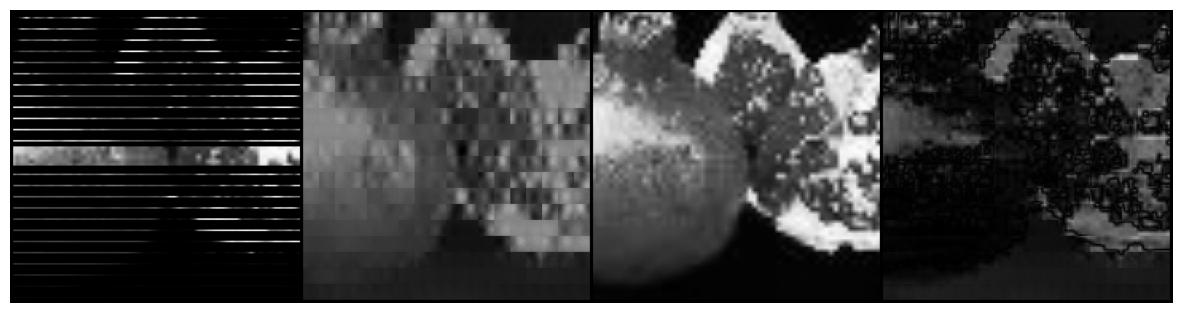

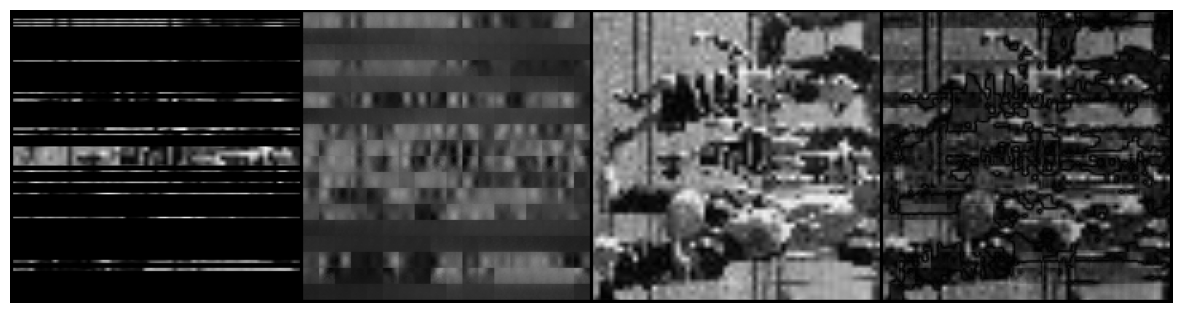

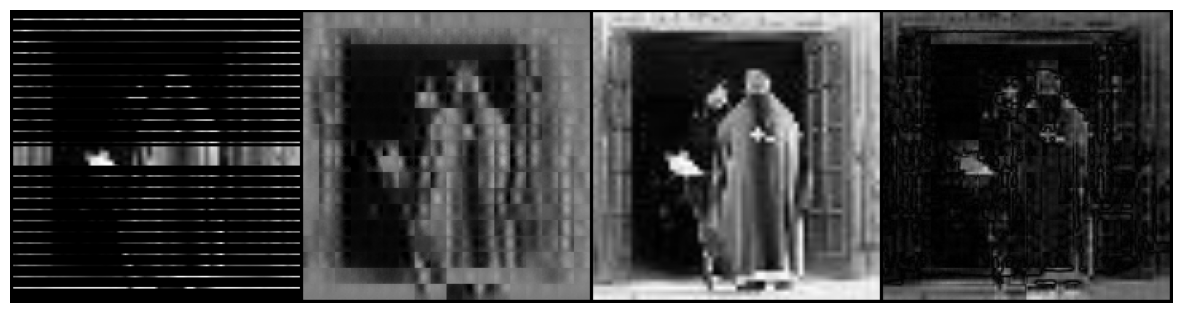

In [26]:
# --------------------------------------------------------------------
# Test the model trained
print("*********** Testing ************", datetime.now())
# --------------------------------------------------------------------

"""Example reconstructions"""
valloader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=0,
    generator=torch.Generator().manual_seed(1),
)
dataiter = iter(valloader)
model.eval()
maxval = torch.tensor([1.0], device="cpu")

ssim_clean = []
ssim_noise = []
psnr_clean = []
psnr_noise = []
nmse_clean = []
nmse_noise = []

testing_data = 3
with torch.no_grad():
    for k in range(0, testing_data):
        inputs, targets = next(dataiter)
        outputs = model(inputs.to(device)).cpu()
        inputs_ = inputs
        img_input = inputs_[0].numpy()
        img_noise = outputs[0].numpy()
        img = targets[0].numpy()

        if k < 5:
            plt.figure(figsize=(15, 7))
            imshow(
                make_grid(
                    [
                        inputs_[0],
                        outputs[0],
                        targets[0],
                        (targets[0] - outputs[0]).abs(),
                    ],
                    normalize=True,
                    value_range=(0, maxval[0]),
                )
            )
            plt.axis("off")
            plt.savefig("output/imagenet_after_spt" + str(k) + ".png")

        ssim_clean.append(ssim(img, img_noise, maxval[0].item()))
        ssim_noise.append(ssim(img, img_input, maxval[0].item()))
        psnr_clean.append(psnr(img, img_noise, maxval[0].item()))
        psnr_noise.append(psnr(img, img_input, maxval[0].item()))
        nmse_clean.append(
            nmse(
                img,
                img_noise,
            )
        )
        nmse_noise.append(nmse(img, img_input))

    output_stat = pd.DataFrame()
    output_stat["ssim_clean"] = ssim_clean
    output_stat["ssim_noise"] = ssim_noise
    output_stat["psnr_clean"] = psnr_clean
    output_stat["psnr_noise"] = psnr_noise
    output_stat["nmse_clean"] = nmse_clean
    output_stat["nmse_noise"] = nmse_noise
    output_stat.to_csv("output/breakdown.csv")

    # output_stat = pd.read_csv("output/testing_metrics.csv")
    testing_metrics = output_stat.mean(axis=0)
    output_stat = pd.concat([output_stat, testing_metrics])
    testing_metrics.to_csv("output/testing_metrics.csv")

    print(" ssim:", testing_metrics["ssim_clean"])
    print("*ssim:", testing_metrics["ssim_noise"])
    print(" psnr:", testing_metrics["psnr_clean"])
    print("*psnr:", testing_metrics["psnr_noise"])
    print(" nmse:", testing_metrics["nmse_clean"])
    print("*nmse:", testing_metrics["nmse_noise"])

print("*********** ENDED AT ************", datetime.now())

# --------------------------------------------------------------------
# Completed running a ViT network with Imagenet dataset
# --------------------------------------------------------------------